# Analysis of Autoencoder results

Analysis of performance of some autoencoder models among different dataset settigns. In particular, we evaluate batch size impact and we choose the best value to fix for later analysis. We then study performances mainly for choosing a good code size.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

Load grid-search reults from file

In [2]:
res_df = pd.read_csv("./models/results.csv")
res_df = res_df.drop(labels=["i"], axis=1)

res_df.head()

,type,loss_val,code_size,optimizer,loss_func,epochs,batch_size,filepath
0,bryan,21.345753,2,adam,mse,150,32,models/encoder_bryan_cs-2_loss-mse_bs-32.h5
1,bryan,18.617182,2,adam,mse,150,128,models/encoder_bryan_cs-2_loss-mse_bs-128.h5
2,bryan,17.751451,3,adam,mse,150,32,models/encoder_bryan_cs-3_loss-mse_bs-32.h5
3,bryan,19.478971,3,adam,mse,150,128,models/encoder_bryan_cs-3_loss-mse_bs-128.h5
4,bryan,14.920699,4,adam,mse,150,32,models/encoder_bryan_cs-4_loss-mse_bs-32.h5


In [3]:
print("len =", len(res_df))
print("type =", res_df["type"].unique())
print("code_size =", res_df["code_size"].unique())
print("batch_size =", res_df["batch_size"].unique())
print("optimizer =", res_df["optimizer"].unique())
print("loss_func =", res_df["loss_func"].unique())
print("epochs =", res_df["epochs"].unique())

len = 150
type = ['bryan' 'default' 'oit_bryan_allpos' 'oit_bryan' 'oit']
code_size = [ 2  3  4  5  6 12 18 24 30 36 42 48 54 60 72]
batch_size = [ 32 128]
optimizer = ['adam']
loss_func = ['mse']
epochs = [150]


Load KNN and FFNN results from file.

In [4]:
validation_df = pd.read_csv("./models/validations.csv")
validation_df = validation_df.drop(["i", "filepath"], axis=1)

validation_df.head()

,accuracy_knn,accuracy_nn,loss_nn
0,0.257982,0.252448,1.795123
1,0.255854,0.252448,1.674897
2,0.124734,0.107280,28.862000
3,0.273308,0.252448,1.870426
4,0.199234,0.218391,19.113821


Join the two dataframe in order to link KNN, FFNN accuracy to the AE loss.

In [5]:
# We do not need to specify l/r-suffix as we dropped repeated column names.
data_df = res_df.join(validation_df)

data_df.head(n=5)

,type,loss_val,code_size,optimizer,loss_func,epochs,batch_size,filepath,accuracy_knn,accuracy_nn,loss_nn
0,bryan,21.345753,2,adam,mse,150,32,models/encoder_bryan_cs-2_loss-mse_bs-32.h5,0.257982,0.252448,1.795123
1,bryan,18.617182,2,adam,mse,150,128,models/encoder_bryan_cs-2_loss-mse_bs-128.h5,0.255854,0.252448,1.674897
2,bryan,17.751451,3,adam,mse,150,32,models/encoder_bryan_cs-3_loss-mse_bs-32.h5,0.124734,0.107280,28.862000
3,bryan,19.478971,3,adam,mse,150,128,models/encoder_bryan_cs-3_loss-mse_bs-128.h5,0.273308,0.252448,1.870426
4,bryan,14.920699,4,adam,mse,150,32,models/encoder_bryan_cs-4_loss-mse_bs-32.h5,0.199234,0.218391,19.113821


## Utils

In [6]:
def get_losses_by_code_size(df):
    x = list(df["code_size"])
    y = list(df["loss_val"])
    return x, y


def get_knn_accuracy_by_code_size(df):
    x = list(df["code_size"])
    y = list(df["accuracy_knn"])
    return x, y


def get_nn_accuracy_by_code_size(df):
    x = list(df["code_size"])
    y = list(df["accuracy_nn"])
    return x, y

## Analysis

Check models on default types. We want to find out whether `batch_size` is relevant or not. 

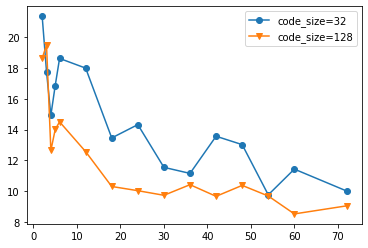

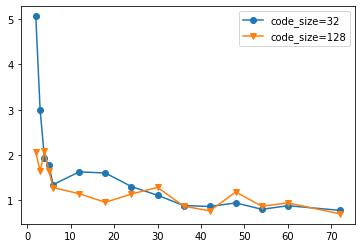

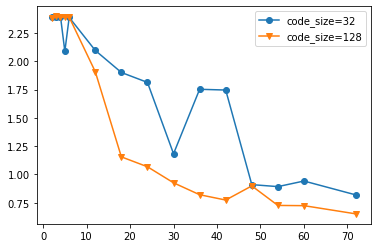

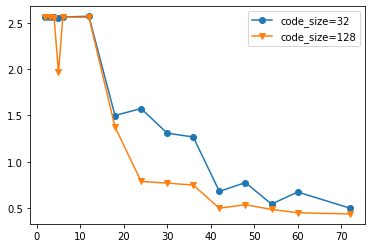

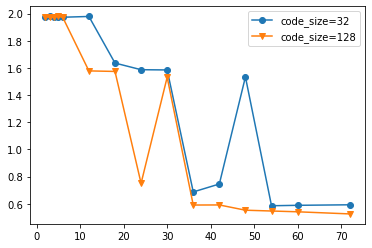

In [25]:
for type in data_df["type"].unique():

    df = data_df.loc[(data_df["type"] == type) & (data_df["batch_size"] == 32)]
    x, y = get_losses_by_code_size(df)
    plt.plot(x, y, marker="o", label="code_size=32")

    df = data_df.loc[(data_df["type"] == type) & (data_df["batch_size"] == 128)]
    x, y = get_losses_by_code_size(df)
    plt.plot(x, y, marker="v", label="code_size=128")

    plt.legend()
    plt.show()

We noticed that with batch size of 32 we could be more robust in term of oscillation, but batch size of 128 could archieve better results. We decided to keep batch size of **128** because it performs better on small codes. 

Let's plot knn/nn accuracy on differnt type datasets/preprocessing pipelines. Knn and nn are trained on each type of dataset and are used to validate the autoencoder models.

type = bryan


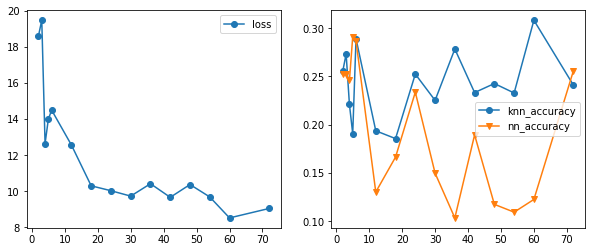

type = default


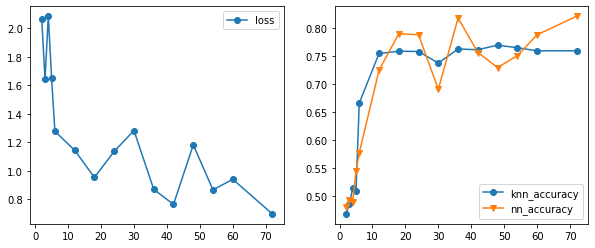

type = oit_bryan_allpos


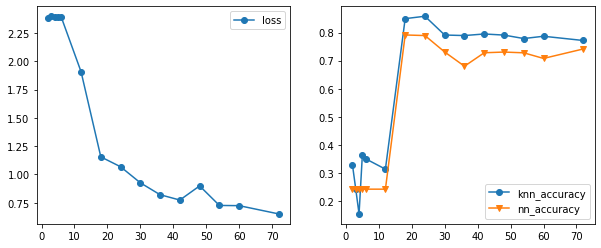

type = oit_bryan


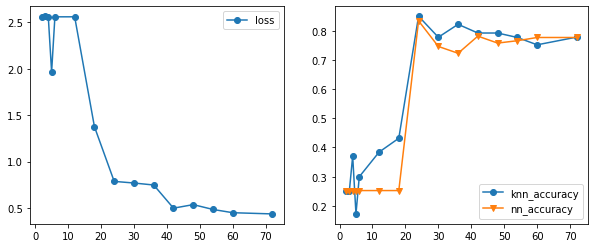

type = oit


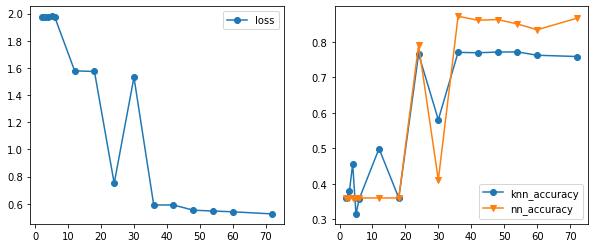

In [24]:
df = data_df

for type in df["type"].unique():
    print(f"type = {type}")
    df = data_df.loc[(data_df["type"] == type) & (data_df["batch_size"] == 128)]

    plt.figure(figsize=(10,4))

    # plot loss
    plt.subplot(1, 2, 1)

    x, y = get_losses_by_code_size(df)
    plt.plot(x, y, marker="o", label="loss")

    plt.legend()

    # plot accuracy
    plt.subplot(1, 2, 2)

    x, y = get_knn_accuracy_by_code_size(df)
    plt.plot(x, y, marker="o", label="knn_accuracy")

    x, y = get_nn_accuracy_by_code_size(df)
    plt.plot(x, y, marker="v", label="nn_accuracy")

    plt.legend()

    plt.show()

We can see that except for `type = default" where the nn oscillates with code_size from 24 to 36, they have the same performances. For comparative purposes we choose as metric the knn accuracy.

Let's now compare how the autoencoder performs in term of loss (mse in our case) on different scenarios:

1. controlled data + ab validation
2. controlled data + ab validation + oit
3. controlled data + bryan validation
4. controlled data + bryan validation + oit
5. controlled data + bryan validation (all positions) + oit

We should see that performances on 1 vs 2 should be pretty the same or lower for 2.

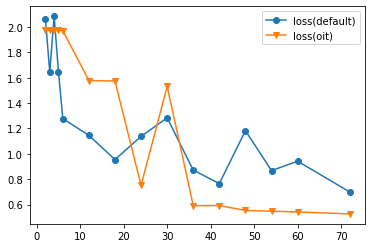

In [23]:
df = data_df.loc[(data_df["type"] == "default") & (data_df["batch_size"] == 128)]

x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="o", label="loss(default)")

df = data_df.loc[(data_df["type"] == "oit") & (data_df["batch_size"] == 128)]

x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="v", label="loss(oit)")

plt.legend()

plt.show()

We shoudl also see that performances on 1 vs 3-4-5 shoudl be higher for 1 (if this is not the case the model is generalizing well).

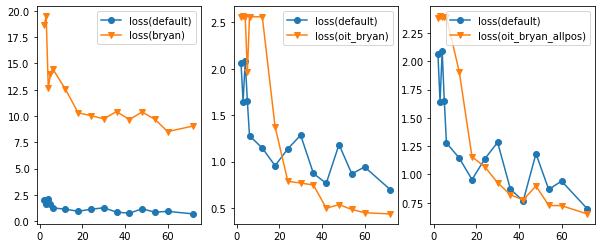

In [22]:
plt.figure(figsize=(10,4))

# plot 1 vs 3
plt.subplot(1, 3, 1)

df = data_df.loc[(data_df["type"] == "default") & (data_df["batch_size"] == 128)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="o", label="loss(default)")

df = data_df.loc[(data_df["type"] == "bryan") & (data_df["batch_size"] == 128)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="v", label="loss(bryan)")

plt.legend()

# plot 1 vs 4
plt.subplot(1, 3, 2)

df = data_df.loc[(data_df["type"] == "default") & (data_df["batch_size"] == 128)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="o", label="loss(default)")

df = data_df.loc[(data_df["type"] == "oit_bryan") & (data_df["batch_size"] == 128)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="v", label="loss(oit_bryan)")

plt.legend()

# plot 1 vs 5
plt.subplot(1, 3, 3)

df = data_df.loc[(data_df["type"] == "default") & (data_df["batch_size"] == 128)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="o", label="loss(default)")

df = data_df.loc[(data_df["type"] == "oit_bryan_allpos") & (data_df["batch_size"] == 128)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="v", label="loss(oit_bryan_allpos)")

plt.legend()

plt.show()

For 3-4-5 we shoudl see that 3 is very poor in performances.

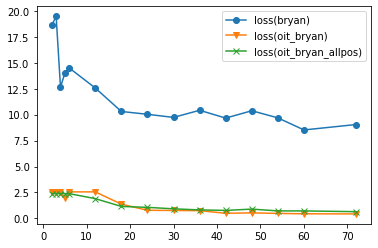

In [20]:
df = data_df.loc[(data_df["type"] == "bryan") & (data_df["batch_size"] == 128)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="o", label="loss(bryan)")

df = data_df.loc[(data_df["type"] == "oit_bryan") & (data_df["batch_size"] == 128)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="v", label="loss(oit_bryan)")

df = data_df.loc[(data_df["type"] == "oit_bryan_allpos") & (data_df["batch_size"] == 128)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="x", label="loss(oit_bryan_allpos)")

plt.legend()

plt.show()

4 should be the same or slightly lower than 1-2.

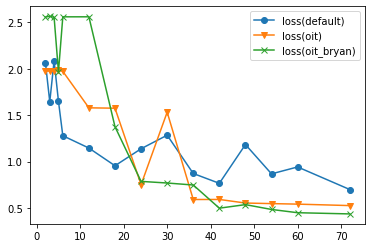

In [19]:
df = data_df.loc[(data_df["type"] == "default") & (data_df["batch_size"] == 128)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="o", label="loss(default)")

df = data_df.loc[(data_df["type"] == "oit") & (data_df["batch_size"] == 128)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="v", label="loss(oit)")

df = data_df.loc[(data_df["type"] == "oit_bryan") & (data_df["batch_size"] == 128)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="x", label="loss(oit_bryan)")

plt.legend()

plt.show()

For 5 wrt 4 we should notice slightly low performances.

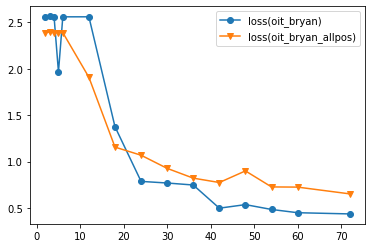

In [18]:
df = data_df.loc[(data_df["type"] == "oit_bryan") & (data_df["batch_size"] == 128)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="o", label="loss(oit_bryan)")

df = data_df.loc[(data_df["type"] == "oit_bryan_allpos") & (data_df["batch_size"] == 128)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, marker="v", label="loss(oit_bryan_allpos)")

plt.legend()

plt.show()

Let's also see how losses change by fixing the (best) code size for autoencoder for every scenario.

In [14]:
df = data_df.copy()

df = df.loc[(df["batch_size"] == 128) & (df["code_size"] == 36)]
print(df[["type", "loss_val", "accuracy_knn", "accuracy_nn"]].head())

                 type   loss_val  accuracy_knn  accuracy_nn
19              bryan  10.421337      0.278416     0.103448
49            default   0.871255      0.762793     0.818093
79   oit_bryan_allpos   0.821241      0.789562     0.680167
109         oit_bryan   0.747241      0.822052     0.722861
139               oit   0.591103      0.770062     0.871820


In [15]:
df = data_df.copy()

df = df.loc[(df["batch_size"] == 128) & (df["code_size"] == 60)]
print(df[["type", "loss_val", "accuracy_knn", "accuracy_nn"]].head())

                 type  loss_val  accuracy_knn  accuracy_nn
27              bryan  8.525445      0.308216     0.122605
57            default  0.941741      0.759552     0.788233
87   oit_bryan_allpos  0.724681      0.787056     0.707933
117         oit_bryan  0.448898      0.751809     0.776926
147               oit  0.541304      0.761909     0.833710
